In [213]:
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Input, InputLayer, Dropout, Dense, Flatten, Embedding, Add, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop

from sklearn.metrics import precision_recall_fscore_support

import matplotlib.pyplot as plt

# Own code
import import_ipynb
import metadata_options
import models_semantic
import models_nn

In [214]:
df = pd.read_csv('./data/kokil dec 6 reprepare/conf_pc_worker_sem.csv')
df = df.dropna()

TP4 + k: weighted by 1 upright k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC3: weighted by 1 PC agreement weight per annotation in each OHE, i.e. (a, b, c, d) -> (w1*a, w2*b, w3*c, w4*d)
TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# RAND_NORM: weighted by 1 normally distributed random number between 0 to 1 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)


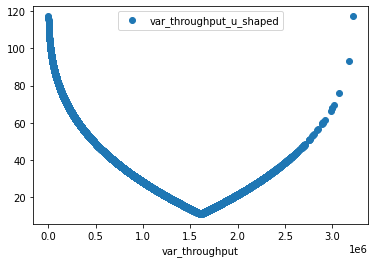

In [215]:
throughput_option = 'TP4'
worktime_option = 'WT2'
pc_agreement_option = 'PC3'
textlength_option = 'TL2'
special_option = 'RAND_NORM'
k_option_for_tp = 3

df_throughput, df_worktime, df_agreement, df_textlength, df_special = metadata_options.set_OHE_pipeline_options(df, throughput_option, worktime_option, pc_agreement_option, textlength_option, special_option, k_option_for_tp)

In [216]:
######################################
## Model Options ##
######################################
# options: randomforest, logreg

model_name = 'logreg'
models_semantic.MODEL_NAME = model_name

In [217]:
df = df.drop(columns=['Input.msg_id', 'HITId', 'Input.sentence_id', 'Input.convo_id', 'Input.train_test_val',
                     'Input.similar_text_id', 'Input.msg_id', 'Input.timestamp', 'Input.full_text',
                      'Input.speaker', 'Input.reply_to', 
                      'Input.game_score_delta', 'Input.game_score_receiver',
                      'Input.speaker_intention', 'Input.reciever_perception', 'Input.reciever',
                      'Input.absolute_message_index', 'Input.relative_message_index', 'Input.year',
                      'Input.game_score_speaker', 'Input.num_words', 'Input.num_characters', 
                      'Input.sno', 'Input.sno1',
                      'WorkTime.1', 'WorkTime.2', 'WorkTime.3', 'WorkTime.4', 'WorkTime.5',
                      'Throughput.1', 'Throughput.2', 'Throughput.3', 'Throughput.4', 'Throughput.5',
                      'Answer.1gamemove.yes', 'Answer.2reasoning.yes',
                      'Answer.3a_apologies.yes', 'Answer.3a_compliment.yes', 'Answer.3a_personalthoughts.yes',
                      'Answer.3a_reassurance.yes', 'Answer.3rapport.yes', 'Answer.4shareinformation.yes', 'count',
                      'Answer.1gamemove.yes_pc_agree', 'Answer.2reasoning.yes_pc_agree', 
                      'Answer.3a_apologies.yes_pc_agree', 'Answer.3a_compliment.yes_pc_agree',
                      'Answer.3a_personalthoughts.yes_pc_agree', 'Answer.3a_reassurance.yes_pc_agree',
                      'Answer.3rapport.yes_pc_agree', 'Answer.4shareinformation.yes_pc_agree', 
                      'message_id.x', 'message_id.y',
                      'Answer.3a_apologies.yes_label', 'Answer.3a_compliment.yes_label',
                      'Answer.3a_personalthoughts.yes_label', 'Answer.3a_reassurance.yes_label'
                     ])

In [218]:
indices = range(df.shape[0])

In [219]:
# New train_test_split using Stratified Shaffled Splits
y = df["Input.deception_quadrant"].copy()
X = df.drop(["Input.deception_quadrant"], axis=1)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
splits_generator = sss.split(X, y)

for train_idx, test_idx in splits_generator:
    indices_train = train_idx
    indices_test = test_idx

train = df.take(indices_train)
test = df.take(indices_test)

new_deception_train = train["Input.deception_quadrant"].copy()
new_deception_train['Input.deception_quadrant'] = train["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_train_deception = new_deception_train['Input.deception_quadrant'].tolist()
y_train_rapport = train['Answer.3rapport.yes_label'].tolist()
y_train_share_information = train['Answer.4shareinformation.yes_label'].tolist()
y_train_reasoning = train['Answer.2reasoning.yes_label'].tolist()
y_train_gamemove = train['Answer.1gamemove.yes_label'].tolist()

new_deception_test = test["Input.deception_quadrant"].copy()
new_deception_test['Input.deception_quadrant'] = test["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_test_deception = new_deception_test['Input.deception_quadrant'].tolist()
y_test_rapport = test['Answer.3rapport.yes_label'].tolist()
y_test_share_information = test['Answer.4shareinformation.yes_label'].tolist()
y_test_reasoning = test['Answer.2reasoning.yes_label'].tolist()
y_test_gamemove = test['Answer.1gamemove.yes_label'].tolist()

X_train = train.drop(columns=['Answer.1gamemove.yes_label', 'Answer.2reasoning.yes_label',
                              'Answer.3rapport.yes_label', 'Answer.4shareinformation.yes_label', 'Input.deception_quadrant'])

X_test = test.drop(columns=['Answer.1gamemove.yes_label', 'Answer.2reasoning.yes_label',
                              'Answer.3rapport.yes_label', 'Answer.4shareinformation.yes_label', 'Input.deception_quadrant'])

### Individual classifiers 

In [220]:
# Game move classifier
clf_gamemove = models_semantic.get_semantic_model()
clf_gamemove.fit(X_train, y_train_gamemove)
y_pred_gamemove = clf_gamemove.predict(X_train)
y_pred_test_gamemove = clf_gamemove.predict(X_test)
print(classification_report(y_pred_gamemove, y_train_gamemove))

              precision    recall  f1-score   support

         0.0       0.00      1.00      0.00         1
         1.0       1.00      0.93      0.96      9091

    accuracy                           0.93      9092
   macro avg       0.50      0.96      0.48      9092
weighted avg       1.00      0.93      0.96      9092



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [221]:
# Rapport classifier
clf_rapport = models_semantic.get_semantic_model()
clf_rapport.fit(X_train, y_train_rapport)
y_pred_rapport = clf_rapport.predict(X_train)
y_pred_test_rapport = clf_rapport.predict(X_test)
print(classification_report(y_pred_rapport, y_train_rapport))

              precision    recall  f1-score   support

         0.0       0.00      1.00      0.00         1
         1.0       1.00      0.86      0.93      9091

    accuracy                           0.86      9092
   macro avg       0.50      0.93      0.46      9092
weighted avg       1.00      0.86      0.92      9092



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [222]:
# Share Information classifier
clf_shareinfo = models_semantic.get_semantic_model()
clf_shareinfo.fit(X_train, y_train_share_information)
y_pred_shareinfo = clf_shareinfo.predict(X_train)
y_pred_test_shareinfo = clf_shareinfo.predict(X_test)
print(classification_report(y_pred_shareinfo, y_train_share_information))

              precision    recall  f1-score   support

         0.0       0.00      1.00      0.00         2
         1.0       1.00      0.84      0.91      9090

    accuracy                           0.84      9092
   macro avg       0.50      0.92      0.46      9092
weighted avg       1.00      0.84      0.91      9092



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [223]:
# Reasoning classifier
clf_reasoning = models_semantic.get_semantic_model()
clf_reasoning.fit(X_train, y_train_reasoning)
y_pred_reasoning = clf_reasoning.predict(X_train)
y_pred_test_reasoning = clf_reasoning.predict(X_test)
print(classification_report(y_pred_reasoning, y_train_reasoning))

              precision    recall  f1-score   support

         0.0       0.00      0.62      0.01         8
         1.0       1.00      0.83      0.91      9084

    accuracy                           0.83      9092
   macro avg       0.50      0.73      0.46      9092
weighted avg       1.00      0.83      0.91      9092



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### One hot encodings 

In [224]:
# Train encodings
pred_df_arr_full = []
pred_df_arr = []
for i in range(0, len(y_pred_gamemove)):  
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = y_pred_gamemove[i]
    pred_obj_1['reasoning'] = y_pred_reasoning[i]
    pred_obj_1['shareinfo'] = y_pred_shareinfo[i]
    pred_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = y_pred_rapport[i]
    pred_df_arr_full.append(pred_obj_2)
    
pred_df_full = pd.DataFrame(pred_df_arr_full)
pred_df = pd.DataFrame(pred_df_arr)

In [225]:
# Test encodings
pred_test_df_arr_full = []
pred_test_df_arr = []

for i in range(0, len(y_pred_test_gamemove)):
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = y_pred_test_gamemove[i]
    pred_obj_1['reasoning'] = y_pred_test_reasoning[i]
    pred_obj_1['shareinfo'] = y_pred_test_shareinfo[i]
    pred_test_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = y_pred_test_rapport[i]
    pred_test_df_arr_full.append(pred_obj_2)
    
pred_test_df_full = pd.DataFrame(pred_test_df_arr_full)
pred_test_df = pd.DataFrame(pred_test_df_arr)

In [226]:
# Train weighted encodings
pred_df_full_throughput = pred_df_full.copy()
pred_df_full_worktime = pred_df_full.copy()
pred_df_throughput = pred_df.copy()
pred_df_worktime = pred_df.copy()

df_throughput_keys = df_throughput.keys().to_list()
throughput_values = df_throughput[df_throughput_keys[-1]].take(indices_train).values
pred_df_full_throughput = pred_df_full_throughput.mul(throughput_values, axis=0)
pred_df_throughput = pred_df_throughput.mul(throughput_values, axis=0)

df_worktime_keys = df_worktime.keys().to_list()
worktime_values = df_worktime[df_worktime_keys[-1]].take(indices_train).values
pred_df_full_worktime = pred_df_full_worktime.mul(worktime_values, axis=0)
pred_df_worktime = pred_df_worktime.mul(worktime_values, axis=0)

df_agreement_keys = df_agreement.keys().to_list()
if len(df_agreement_keys) == 5:
    agreement_values = df_agreement[df_agreement_keys[-1]].take(indices_train).values
    pred_df_full_agreement = pred_df_full_throughput.mul(agreement_values, axis=0)
    pred_df_agreement = pred_df_throughput.mul(agreement_values, axis=0)
elif len(df_agreement_keys) == 4:
    agreement_values = df_agreement.take(indices_train)
    pred_df_full_agreement = np.multiply(pred_df_full_throughput, agreement_values)
    agreement_values_wo_rapport = agreement_values.drop(columns=['Answer.3rapport.yes_pc_agree'])
    pred_df_agreement = np.multiply(pred_df_throughput, agreement_values_wo_rapport)
    
textlength_values = df_textlength.take(indices_train).values
pred_df_full_textlength = pred_df_full_throughput.mul(textlength_values, axis=0)
pred_df_textlength = pred_df_throughput.mul(textlength_values, axis=0)

df_special_keys = df_special.keys().to_list()
special_values = df_special[df_special_keys[-1]].take(indices_train).values
pred_df_full_special = pred_df_full_throughput.mul(special_values, axis=0)
pred_df_special = pred_df_throughput.mul(special_values, axis=0)

In [227]:
# Test weighted encodings
pred_df_full_throughput_test = pred_test_df_full.copy()
pred_df_full_worktime_test = pred_test_df_full.copy()
pred_df_throughput_test = pred_test_df.copy()
pred_df_worktime_test = pred_test_df.copy()

df_throughput_keys = df_throughput.keys().to_list()
throughput_values_test = df_throughput[df_throughput_keys[-1]].take(indices_test).values
pred_df_full_throughput_test = pred_df_full_throughput_test.mul(throughput_values_test, axis=0)
pred_df_throughput_test = pred_df_throughput_test.mul(throughput_values_test, axis=0)

df_worktime_keys = df_worktime.keys().to_list()
worktime_values_test = df_worktime[df_worktime_keys[-1]].take(indices_test).values
pred_df_full_worktime_test = pred_df_full_worktime_test.mul(worktime_values_test, axis=0)
pred_df_worktime_test = pred_df_worktime_test.mul(worktime_values_test, axis=0)

df_agreement_keys = df_agreement.keys().to_list()
if len(df_agreement_keys) == 5:
    agreement_values_test = df_agreement[df_agreement_keys[-1]].take(indices_test).values
    pred_df_full_agreement_test = pred_df_full_throughput_test.mul(agreement_values_test, axis=0)
    pred_df_agreement_test = pred_df_throughput_test.mul(agreement_values_test, axis=0)
elif len(df_agreement_keys) == 4:
    agreement_values_test = df_agreement.take(indices_test)
    pred_df_full_agreement_test = np.multiply(pred_df_full_throughput_test, agreement_values_test)
    agreement_values_wo_rapport_test = agreement_values_test.drop(columns=['Answer.3rapport.yes_pc_agree'])
    pred_df_agreement_test = np.multiply(pred_df_throughput_test, agreement_values_wo_rapport_test)
    
textlength_values_test = df_textlength.take(indices_test).values
pred_df_full_textlength_test = pred_df_full_throughput_test.mul(textlength_values_test, axis=0)
pred_df_textlength_test = pred_df_throughput_test.mul(textlength_values_test, axis=0)

df_special_keys = df_special.keys().to_list()
special_values_test = df_special[df_special_keys[-1]].take(indices_test).values
pred_df_full_special_test = pred_df_full_throughput_test.mul(special_values_test, axis=0)
pred_df_special_test = pred_df_throughput_test.mul(special_values_test, axis=0)

### Joint model is dense layer

In [228]:
y_train_deception = np.array(y_train_deception)
y_test_deception = np.array(y_test_deception)

y_train_rapport = np.array(y_train_rapport)
y_test_rapport = np.array(y_test_rapport)

In [229]:
print('Joint full model with one hot encoding, predicting deception')
joint_full_model = models_nn.create_joint_model(pred_df_full)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_test_df_full,y_test_deception), callbacks=[models_nn.early_stop])

Joint full model with one hot encoding, predicting deception
Model: "functional_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_62 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_185 (Dense)            (None, 2)                 10        
_________________________________________________________________
dense_186 (Dense)            (None, 4)                 12        
_________________________________________________________________
dense_187 (Dense)            (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 4ms/step - loss: 0.7200 - acc: 0.4008 - f1_m: 0.3881 - precision_m: 0.3982 - recall_m: 0.3988 - val_loss: 0.6284 - val_acc: 0.9507 - val

In [230]:
full_pred = joint_full_model.predict(pred_df_full)
full_pred = np.argmax(full_pred, axis=1)

full_pred_test = joint_full_model.predict(pred_test_df_full)
full_pred_test = np.argmax(full_pred_test, axis=1)

In [231]:
precision_recall_fscore_support(y_test_deception, full_pred_test, average='macro')

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.024626209322779244, 0.5, 0.04694048616932104, None)

In [232]:
y_train_rapport = np.array(y_train_rapport)
y_test_rapport = np.array(y_test_rapport)

print('Joint full model with one hot encoding, predicting rapport')
joint_full_model_rapport = models_nn.create_joint_model(pred_df)
joint_full_model_rapport.summary()
history = joint_full_model_rapport.fit(x=pred_df, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_test_df,y_test_rapport), callbacks=[models_nn.early_stop])

Joint full model with one hot encoding, predicting rapport
Model: "functional_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_188 (Dense)            (None, 2)                 8         
_________________________________________________________________
dense_189 (Dense)            (None, 4)                 12        
_________________________________________________________________
dense_190 (Dense)            (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6485 - acc: 0.8554 - f1_m: 0.9184 - precision_m: 0.8553 - recall_m: 0.9930 - val_loss: 0.5691 - val_acc: 0.8712 - val_f

In [233]:
full_pred = joint_full_model_rapport.predict(pred_df)
full_pred = np.argmax(full_pred, axis=1)

full_pred_test = joint_full_model_rapport.predict(pred_test_df)
full_pred_test = np.argmax(full_pred_test, axis=1)

precision_recall_fscore_support(y_test_rapport, full_pred_test, average='macro')

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.06442392260334213, 0.5, 0.11414102064666927, None)

In [234]:
print('Joint full model with one hot encoding, predicting deception, weighted by throughput')
joint_full_model = models_nn.create_joint_model(pred_df_full_throughput)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_throughput, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_full_throughput_test,y_test_deception), callbacks=[models_nn.early_stop])

Joint full model with one hot encoding, predicting deception, weighted by throughput
Model: "functional_129"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_64 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_191 (Dense)            (None, 2)                 10        
_________________________________________________________________
dense_192 (Dense)            (None, 4)                 12        
_________________________________________________________________
dense_193 (Dense)            (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6623 - acc: 0.9446 - f1_m: 0.9680 - precision_m: 0.9446 - recall_m: 0.9930 - val_loss: 0.6321

143/143 [==============================] - 0s 3ms/step - loss: 0.2033 - acc: 0.9509 - f1_m: 0.9748 - precision_m: 0.9513 - recall_m: 1.0000 - val_loss: 0.2031 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.2020 - acc: 0.9509 - f1_m: 0.9748 - precision_m: 0.9513 - recall_m: 1.0000 - val_loss: 0.2019 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.2009 - acc: 0.9509 - f1_m: 0.9748 - precision_m: 0.9513 - recall_m: 1.0000 - val_loss: 0.2008 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.1999 - acc: 0.9509 - f1_m: 0.9726 - precision_m: 0.9480 - recall_m: 1.0000 - val_loss: 0.2000 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_r

In [235]:
full_pred = joint_full_model.predict(pred_df_full)
full_pred = np.argmax(full_pred, axis=1)

full_pred_test = joint_full_model.predict(pred_test_df_full)
full_pred_test = np.argmax(full_pred_test, axis=1)

precision_recall_fscore_support(y_test_deception, full_pred_test, average='macro')

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.024626209322779244, 0.5, 0.04694048616932104, None)

In [236]:
y_train_rapport = np.array(y_train_rapport).astype(int)
y_test_rapport = np.array(y_test_rapport).astype(int)

In [237]:
print('Joint full model with one hot encoding, predicting rapport, weighted by throughput')
joint_full_model_rapport = models_nn.create_joint_model(pred_df_throughput)
joint_full_model_rapport.summary()
history = joint_full_model_rapport.fit(x=pred_df_throughput, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_throughput_test,y_test_rapport), callbacks=[models_nn.early_stop])

Joint full model with one hot encoding, predicting rapport, weighted by throughput
Model: "functional_131"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_194 (Dense)            (None, 2)                 8         
_________________________________________________________________
dense_195 (Dense)            (None, 4)                 12        
_________________________________________________________________
dense_196 (Dense)            (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 7ms/step - loss: 0.4536 - acc: 0.8604 - f1_m: 0.9249 - precision_m: 0.8613 - recall_m: 1.0000 - val_loss: 0.3891 -

In [238]:
full_pred_test = joint_full_model_rapport.predict(pred_df_throughput_test)
full_pred_test = np.argmax(full_pred_test, axis=1)

precision_recall_fscore_support(y_test_rapport, full_pred_test, average='macro')

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.06442392260334213, 0.5, 0.11414102064666927, None)

In [239]:
print('Joint full model with one hot encoding, predicting deception, weighted by worktime')
joint_full_model = models_nn.create_joint_model(pred_df_full_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_worktime, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_full_worktime_test,y_test_deception), callbacks=[models_nn.early_stop])

full_pred_test = joint_full_model.predict(pred_df_full_worktime_test)
full_pred_test = np.argmax(full_pred_test, axis=1)

precision_recall_fscore_support(y_test_deception, full_pred_test, average='macro')

Joint full model with one hot encoding, predicting deception, weighted by worktime
Model: "functional_133"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_66 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_197 (Dense)            (None, 2)                 10        
_________________________________________________________________
dense_198 (Dense)            (None, 4)                 12        
_________________________________________________________________
dense_199 (Dense)            (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6178 - acc: 0.9427 - f1_m: 0.9661 - precision_m: 0.9428 - recall_m: 0.9913 - val_loss: 0.5278 -

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.024626209322779244, 0.5, 0.04694048616932104, None)

In [240]:
print('Joint full model with one hot encoding, predicting rapport, weighted by worktime')
joint_full_model = models_nn.create_joint_model(pred_df_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_worktime, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_worktime_test,y_test_rapport), callbacks=[models_nn.early_stop])

full_pred_test = joint_full_model.predict(pred_df_worktime_test)
full_pred_test = np.argmax(full_pred_test, axis=1)

precision_recall_fscore_support(y_test_rapport, full_pred_test, average='macro')

Joint full model with one hot encoding, predicting rapport, weighted by worktime
Model: "functional_135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_67 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_200 (Dense)            (None, 2)                 8         
_________________________________________________________________
dense_201 (Dense)            (None, 4)                 12        
_________________________________________________________________
dense_202 (Dense)            (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6510 - acc: 0.8551 - f1_m: 0.9174 - precision_m: 0.8536 - recall_m: 0.9930 - val_loss: 0.5673 - v

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.06442392260334213, 0.5, 0.11414102064666927, None)

In [241]:
print('Joint full model with one hot encoding, predicting deception, weighted by agreement')
joint_full_model = models_nn.create_joint_model(pred_df_full_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_agreement, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_full_agreement_test,y_test_deception), callbacks=[models_nn.early_stop])

full_pred_test = joint_full_model.predict(pred_df_full_agreement_test)
full_pred_test = np.argmax(full_pred_test, axis=1)

precision_recall_fscore_support(y_test_deception, full_pred_test, average='macro')

Joint full model with one hot encoding, predicting deception, weighted by agreement
Model: "functional_137"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_68 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_203 (Dense)            (None, 2)                 10        
_________________________________________________________________
dense_204 (Dense)            (None, 4)                 12        
_________________________________________________________________
dense_205 (Dense)            (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 6ms/step - loss: 0.6289 - acc: 0.9507 - f1_m: 0.9747 - precision_m: 0.9512 - recall_m: 0.9998 - val_loss: 0.5527 

143/143 [==============================] - 0s 3ms/step - loss: 0.1958 - acc: 0.9509 - f1_m: 0.9748 - precision_m: 0.9513 - recall_m: 1.0000 - val_loss: 0.1969 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.1958 - acc: 0.9509 - f1_m: 0.9748 - precision_m: 0.9513 - recall_m: 1.0000 - val_loss: 0.1968 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.1958 - acc: 0.9509 - f1_m: 0.9739 - precision_m: 0.9496 - recall_m: 1.0000 - val_loss: 0.1968 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.1959 - acc: 0.9509 - f1_m: 0.9748 - precision_m: 0.9513 - recall_m: 1.0000 - val_loss: 0.1968 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_r

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.024626209322779244, 0.5, 0.04694048616932104, None)

In [242]:
print('Joint full model with one hot encoding, predicting rapport, weighted by agreement')
joint_full_model = models_nn.create_joint_model(pred_df_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_agreement, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_agreement_test,y_test_rapport), callbacks=[models_nn.early_stop])

full_pred_test = joint_full_model.predict(pred_df_agreement_test)
full_pred_test = np.argmax(full_pred_test, axis=1)

precision_recall_fscore_support(y_test_rapport, full_pred_test, average='macro')

Joint full model with one hot encoding, predicting rapport, weighted by agreement
Model: "functional_139"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_69 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_206 (Dense)            (None, 2)                 8         
_________________________________________________________________
dense_207 (Dense)            (None, 4)                 12        
_________________________________________________________________
dense_208 (Dense)            (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.4763 - acc: 0.8604 - f1_m: 0.9239 - precision_m: 0.8597 - recall_m: 1.0000 - val_loss: 0.3787 - 

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.06442392260334213, 0.5, 0.11414102064666927, None)

In [ ]:
print('Joint full model with one hot encoding, predicting deception, weighted by text length')
joint_full_model = models_nn.create_joint_model(pred_df_full_textlength_test)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_textlength, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_full_textlength_test,y_test_deception), callbacks=[models_nn.early_stop])

full_pred_test = joint_full_model.predict(pred_df_full_textlength_test)
full_pred_test = np.argmax(full_pred_test, axis=1)

precision_recall_fscore_support(y_test_deception, full_pred_test, average='macro')

Joint full model with one hot encoding, predicting deception, weighted by text length
Model: "functional_141"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_70 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_209 (Dense)            (None, 2)                 10        
_________________________________________________________________
dense_210 (Dense)            (None, 4)                 12        
_________________________________________________________________
dense_211 (Dense)            (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.5831 - acc: 0.9509 - f1_m: 0.9748 - precision_m: 0.9513 - recall_m: 1.0000 - val_loss: 0.484

In [ ]:
print('Joint full model with one hot encoding, predicting rapport, weighted by text length')
joint_full_model = models_nn.create_joint_model(pred_df_textlength)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_textlength, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_textlength_test,y_test_rapport), callbacks=[models_nn.early_stop])

full_pred_test = joint_full_model.predict(pred_df_textlength_test)
full_pred_test = np.argmax(full_pred_test, axis=1)

precision_recall_fscore_support(y_test_rapport, full_pred_test, average='macro')

In [ ]:
## Joint full model with semantic model, predicting deception
clf_joint = models_semantic.get_semantic_model()
clf_joint.fit(pred_df_full, y_train_deception)
y_pred_deception = clf_joint.predict(pred_df_full)
y_pred_test_deception = clf_joint.predict(pred_test_df_full)
print(classification_report(y_pred_test_deception, y_test_deception))

precision_recall_fscore_support(y_test_deception, y_pred_test_deception, average='macro')

In [ ]:
## Joint full model with semantic model, predicting rapport
clf_joint = models_semantic.get_semantic_model()
clf_joint.fit(pred_df, y_train_rapport)
y_pred_repport = clf_joint.predict(pred_df)
y_pred_test_rapport = clf_joint.predict(pred_test_df)
print(classification_report(y_pred_test_rapport, y_test_rapport))

precision_recall_fscore_support(y_test_rapport, y_pred_test_rapport, average='macro')

In [ ]:
## Joint full model with semantic model, predicting deception, weighted by throughput
clf_joint = models_semantic.get_semantic_model()
clf_joint.fit(pred_df_full_throughput, y_train_deception)
y_pred_deception = clf_joint.predict(pred_df_full_throughput)
y_pred_test_deception = clf_joint.predict(pred_df_full_throughput_test)
print(classification_report(y_pred_test_deception, y_test_deception))

precision_recall_fscore_support(y_test_deception, y_pred_test_deception, average='macro')

In [ ]:
## Joint full model with semantic model, predicting rapport, weighted by throughput
clf_joint = models_semantic.get_semantic_model()
clf_joint.fit(pred_df_throughput, y_train_rapport)
y_pred_rapport = clf_joint.predict(pred_df_throughput)
y_pred_test_rapport = clf_joint.predict(pred_df_throughput_test)
print(classification_report(y_pred_test_rapport, y_test_rapport))

precision_recall_fscore_support(y_test_rapport, y_pred_test_rapport, average='macro')

In [ ]:
## Joint full model with semantic model, predicting deception, weighted by worktime
clf_joint = models_semantic.get_semantic_model()
clf_joint.fit(pred_df_full_worktime, y_train_deception)
y_pred_test = clf_joint.predict(pred_df_full_worktime_test)
print(classification_report(y_pred_test, y_test_deception))

precision_recall_fscore_support(y_pred_test, y_test_deception, average='macro')

In [ ]:
## Joint full model with semantic model, predicting rapport, weighted by worktime
clf_joint = models_semantic.get_semantic_model()
clf_joint.fit(pred_df_worktime, y_train_rapport)
y_pred_test_rapport = clf_joint.predict(pred_df_worktime_test)
print(classification_report(y_pred_test_rapport, y_test_rapport))

precision_recall_fscore_support(y_pred_test_rapport, y_test_rapport, average='macro')

In [ ]:
## Joint full model with semantic model, predicting deception, weighted by agreement
clf_joint = models_semantic.get_semantic_model()
clf_joint.fit(pred_df_full_agreement, y_train_deception)
y_pred_test = clf_joint.predict(pred_df_full_agreement_test)
print(classification_report(y_pred_test, y_test_deception))

precision_recall_fscore_support(y_pred_test, y_test_deception, average='macro')

In [ ]:
## Joint full model with semantic model, predicting rapport, weighted by agreement
clf_joint = models_semantic.get_semantic_model()
clf_joint.fit(pred_df_agreement, y_train_rapport)
y_pred_test_rapport = clf_joint.predict(pred_df_agreement_test)
print(classification_report(y_pred_test_rapport, y_test_rapport))

precision_recall_fscore_support(y_pred_test_rapport, y_test_rapport, average='macro')

## Other special options (either SP1, SP2, SP3, RAND_UNI, or RAND_NORM)

In [ ]:
print('Joint full model with one hot encoding, predicting deception, weighted by special option')
joint_full_model = models_nn.create_joint_model(pred_df_full_special)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_special, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_special_test,y_test_deception), 
                               callbacks=[models_nn.early_stop])

joint_predict = joint_full_model.predict(pred_df_full_special_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

In [ ]:
print('Joint full model with one hot encoding, predicting rapport, weighted by special option')
joint_full_model = models_nn.create_joint_model(pred_df_special)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_special, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_special_test,y_test_rapport), 
                               callbacks=[models_nn.early_stop])

joint_predict = joint_full_model.predict(pred_df_special_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')